In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import os
import time
import math
import shutil
import soundfile as sf
import scipy.signal
from scipy.io import wavfile

import imageio
import librosa
import librosa.display
from IPython.display import Audio

torch.cuda.is_available()

False

## Display Graphs

#### display_graphs_bool

In [2]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs(epoch, accuracy, val_accuracy, loss, val_loss, csv_dir):
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)

    if (epoch+1) % interval == 0 or (epoch-1) == num_epochs:
        if epoch != 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
            axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o', markersize=4, color='#32a852')
            axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o', markersize=4, color='#312af7')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Accuracy')
            axs[0].set_title('Training and Validation Accuracy')
            axs[0].set_ylim(acc_min_y, 1)
            axs[0].set_xlim(1, num_epochs)
            axs[0].legend()
            major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[0].set_xticks(major_ticks)
            axs[0].set_xticks(minor_ticks, minor=True)
            axs[0].set_xticklabels(major_ticks.astype(int))
            axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

            # Plot the loss graph in the second subplot
            axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o', markersize=4, color='#32a852')
            axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o', markersize=4, color='#312af7')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Loss')
            axs[1].set_title('Training and Validation Loss')
            axs[1].set_ylim(loss_min_y, loss_max_y)
            axs[1].set_xlim(1, num_epochs)
            axs[1].legend()
            major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()

            # Create a dictionary with your data
            data = {
                'Epoch': metrics_epoch,
                'Train Accuracy': metrics_train_accuracy,
                'Validation Accuracy': metrics_val_accuracy,
                'Train Loss': metrics_train_loss,
                'Validation Loss': metrics_val_loss
            }

            # Create a pandas DataFrame from your dictionary
            df = pd.DataFrame(data)
            # Save DataFrame to csv
            file_path = os.path.join(csv_dir, 'metrics.csv')
            df.to_csv(file_path, index=False)

#### display_graphs_zoomed_bool

In [3]:
# Lists to store accuracy values for each epoch
metrics_train_accuracy = []
metrics_val_accuracy = []
metrics_train_loss = []
metrics_val_loss = []
metrics_epoch = []

def display_graphs_zoomed(epoch, accuracy, val_accuracy, loss, val_loss):
    if isinstance(loss, torch.Tensor):
        loss = loss.cpu()

    loss = loss.detach().numpy()

    metrics_epoch.append(epoch+1)
    metrics_train_accuracy.append(accuracy)
    metrics_val_accuracy.append(val_accuracy)
    metrics_train_loss.append(loss)
    metrics_val_loss.append(val_loss)

    # calc y limit for accuracy
    if accuracy < val_accuracy:
        acc_y_lim = accuracy
    else:
        acc_y_lim = val_accuracy
    acc_y_lim = acc_y_lim - (acc_y_lim * 0.5)
    # TypeError: can't multiply sequence by non-int of type 'float'

    acc_y_lim = math.floor(acc_y_lim * 10) / 10

    # calc y limit for loss
    if loss > val_loss:
        val_y_lim = loss
    else:
        val_y_lim = val_loss

    if (epoch+1) % interval == 0 or (epoch-1) == num_epochs:
        if epoch != 0:
            fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # Create a figure with two subplots
            # Plot the accuracy graph in the first subplot
            axs[0].plot(metrics_epoch, metrics_train_accuracy, label='Training Accuracy', marker='o', markersize=4, color='#32a852')
            axs[0].plot(metrics_epoch, metrics_val_accuracy, label='Validation Accuracy', marker='o', markersize=4, color='#312af7')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('Accuracy')
            axs[0].set_title('Training and Validation Accuracy')
            axs[0].set_ylim(acc_y_lim, 1)
            axs[0].set_xlim(1, num_epochs)
            axs[0].grid(True, linestyle='--', alpha=0.5)
            axs[0].legend()
            major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            # Plot the loss graph in the second subplot
            axs[1].plot(metrics_epoch, metrics_train_loss, label='Training Loss', marker='o', markersize=4, color='#32a852')
            axs[1].plot(metrics_epoch, metrics_val_loss, label='Validation Loss', marker='o', markersize=4, color='#312af7')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('Loss')
            axs[1].set_title('Training and Validation Loss')
            axs[1].set_ylim(0, val_y_lim)
            axs[1].set_xlim(1, num_epochs)
            axs[1].set_xticks(range(1, num_epochs + 1, major_tick_spacing))
            axs[1].grid(True, linestyle='--', alpha=0.5)
            axs[1].legend()
            major_ticks = np.arange(0, num_epochs + 1, 5)
            minor_ticks = np.arange(0, num_epochs + 1, 1)
            axs[1].set_xticks(major_ticks)
            axs[1].set_xticks(minor_ticks, minor=True)
            axs[1].set_xticklabels(major_ticks.astype(int))
            axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

            plt.tight_layout()
            plt.show()

            # Create a dictionary with your data
            data = {
                'Epoch': metrics_epoch,
                'Train Accuracy': metrics_train_accuracy,
                'Validation Accuracy': metrics_val_accuracy,
                'Train Loss': metrics_train_loss,
                'Validation Loss': metrics_val_loss
            }

            # Create a pandas DataFrame from your dictionary
            df = pd.DataFrame(data)
            # Save DataFrame to csv
            file_path = os.path.join(csv_dir, 'metrics.csv')
            df.to_csv(file_path, index=False)

## Data

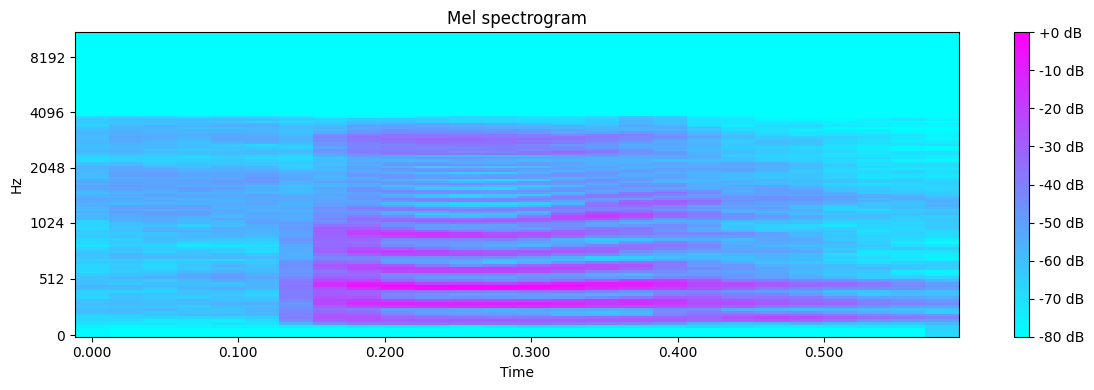

[[1.93414562e-05 9.98709038e-06 2.66127768e-06 ... 3.00526949e-06
  1.32965088e-05 2.18132132e-04]
 [2.01732146e-05 5.50461618e-06 1.95616053e-07 ... 2.14657661e-07
  1.07958049e-05 2.63668888e-04]
 [1.97226000e-05 4.82689575e-06 2.31364970e-06 ... 1.93271103e-06
  1.26003415e-05 3.04352725e-04]
 ...
 [4.82926277e-09 1.20018551e-09 7.13517394e-18 ... 3.88092828e-17
  2.07342074e-10 6.39720099e-09]
 [4.70894701e-09 1.17026611e-09 6.13149325e-18 ... 1.83451421e-17
  2.04847528e-10 6.31992325e-09]
 [4.63405803e-09 1.15164878e-09 6.18109886e-18 ... 1.82303080e-17
  2.03209380e-10 6.26921093e-09]]


In [4]:
# Convert audio to a Mel spectrogram
y, sr = librosa.load("My_Data/Audio/4/4_george_8.wav")
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
log_S = librosa.power_to_db(S, ref=np.max)

# Display the Mel spectrogram
plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel',  cmap='cool')
plt.title('Mel spectrogram')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()
plt.show()

print(S)

#### Play an example audio file

#### Display audio as mel spectogram

#### Batch convert audio to mel spectogram

In [10]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load an audio file
file_path = r'C:\Users\NUhunsere\fine_tuning_project\My_Data\Audio\7\7_george_5.wav'  
y, sr = librosa.load(file_path, sr=8000) 

# Generate a mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get the dimensions of the mel spectrogram
freq_bins, time_frames = mel_db.shape

# Create a mesh grid for plotting
x, y = np.meshgrid(np.arange(time_frames), np.arange(freq_bins))

# Plot the surface
surf = ax.plot_surface(x, y, mel_db, cmap='viridis')

# Set labels and title
ax.set_xlabel('Time Frames')
ax.set_ylabel('Frequency Bins')
ax.set_zlabel('dB')
ax.set_title('3D Mel Spectrogram')

# Add a color bar for reference
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

# Save the 3D plot as an image
output_file_path = 'mel_spectrogram_3d.png'  # Path where you want to save the image
plt.savefig(output_file_path, dpi=300, bbox_inches='tight')
plt.close(fig)  # Close the figure to free up memory

print(f"3D mel spectrogram saved as {output_file_path}")

3D mel spectrogram saved as mel_spectrogram_3d.png


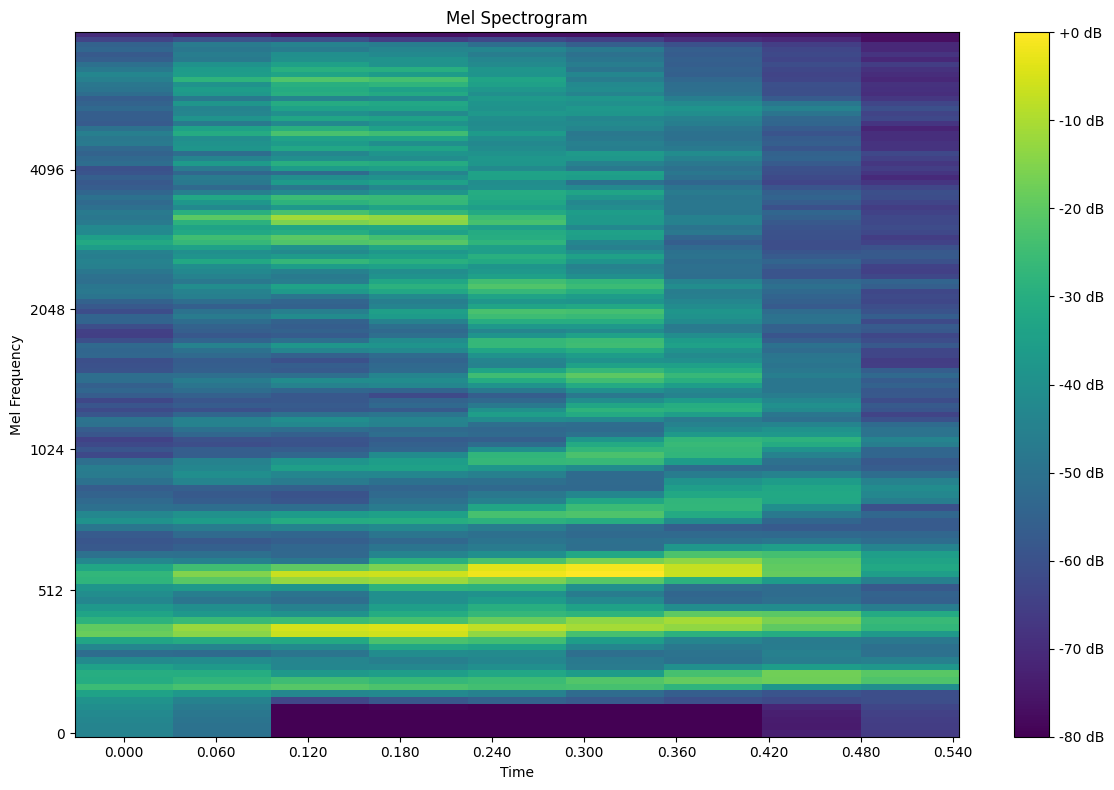

In [20]:
import librosa
import numpy as np
import matplotlib.pyplot as plt

# Load an audio file
file_path = r'My_Data/Audio/0/0_george_15.wav'  # Replace with the path to your audio file
y, sr = librosa.load(file_path, sr=8000)  # Load the audio file with a sampling rate of 8000 Hz

# Generate a mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
mel_db = librosa.power_to_db(mel_spec, ref=np.max)

# Create a figure and axis for plotting
plt.figure(figsize=(12, 8))

# Display the mel spectrogram
img = librosa.display.specshow(mel_db, 
                               x_axis='time', 
                               y_axis='mel', 
                               sr=sr, 
                               fmax=8000,
                               cmap='viridis')

# Add a color bar
plt.colorbar(img, format='%+2.0f dB')

# Set title and labels
plt.title('Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')

# Show the plot
plt.tight_layout()
plt.show()

# Optionally, save the figure
# plt.savefig('mel_spectrogram.png', dpi=300, bbox_inches='tight')

Processing files in directory 0:   0%|          | 0/300 [00:00<?, ?it/s]

OSError: cannot write mode F as PNG

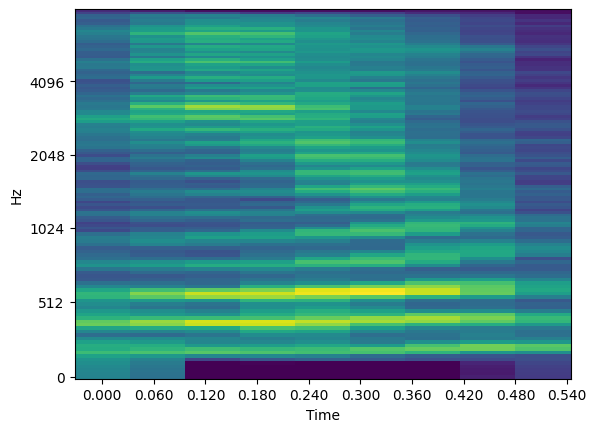

In [22]:
# Define the source and target directories
src_dir = r'My_Data\Audio'
target_dir = r'My_DataData\Mel'

# Loop over subdirectories 0-9
for i in range(10):
    src_subdir = os.path.join(src_dir, str(i))
    target_subdir = os.path.join(target_dir, str(i))

    # Create target subdirectory if it doesn't exist
    os.makedirs(target_subdir, exist_ok=True)

    # Get list of files in source subdirectory
    files = os.listdir(src_subdir)

    # Loop over files in source subdirectory with tqdm progress bar
    for file_name in tqdm(files, desc=f'Processing files in directory {i}'):
        src_file_path = os.path.join(src_subdir, file_name)
        target_file_path = os.path.join(target_subdir, file_name.replace('.wav', '.png'))

        # Convert audio to a Mel spectrogram
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
        mel_db = librosa.power_to_db(mel_spec, ref=np.max)
        img = librosa.display.specshow(mel_db, 
                               x_axis='time', 
                               y_axis='mel', 
                               sr=sr, 
                               fmax=8000,
                               cmap='viridis')


        
        



        # Normalize to [0, 255] and convert to uint8
        # img = ((log_S - log_S.min()) / (log_S.max() - log_S.min()) * 255).astype(np.uint8)

        # Save the Mel spectrogram as a PNG image
        imageio.imwrite(target_file_path, mel_db )


## Model

In [7]:
# Load the pretrained model
model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')

# If you want to do finetuning then set requires_grad = False
# This will freeze the weights for all layers
for param in model.parameters():
    param.requires_grad = False

model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# Replace the last layer for 10 classes
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 10),
    nn.Sigmoid()
)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\NUhunsere/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:03<00:00, 11.8MB/s]


In [8]:
print(type(model))

<class 'torchvision.models.resnet.ResNet'>


#### Define parameters

In [9]:
batch_size = 16
num_epochs = 300
image_size = (16, 128)
learning_rate = 0.001
use_scheduler = True

display_graphs_bool = True
acc_min_y = 0.8
loss_max_y = 2
loss_min_y = 1
major_tick_spacing = 20
display_graphs_zoomed_bool = False
interval = 100
debug = False

In [10]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
if use_scheduler:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.9)

#### Preprocess Data

In [13]:
data_dir = r"C:\Users\NUhunsere\fine_tuning_project\My_Data\Mel_Specs"

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.clamp(0, 1))
])

# Load the data
full_dataset = ImageFolder(data_dir, transform=transform)

# Split the data into training and test sets
train_size = int(0.8 * len(full_dataset))  # 80% for training
test_size = len(full_dataset) - train_size  # 20% for testing
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
batch_size = 16
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print(len(test_dataset))
print(len(train_dataset))


print(f"Moving model to device...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
print(f"Device count: {device}")
model.to(device)  # Move the model to the device (CPU or GPU)
print("Complete")

print("Setting up model...")
model.train()  # Set the model to training mode

loss_function = nn.CrossEntropyLoss()  # Define the loss function
model.zero_grad()  # Reset gradients tensors
optimizer.zero_grad()  # Reset optimizer gradients
print("Complete")

total_steps = len(train_loader)  # Total number of steps in an epoch

600
2400
Moving model to device...
Device count: cpu
Complete
Setting up model...
Complete


#### Save callback

In [14]:
checkpoint_dir = "ModelSaves\M2"
model_name = "M2"
os.makedirs(checkpoint_dir, exist_ok=True)

def save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    checkpoint_path = os.path.join(checkpoint_dir, f'{model_name}_epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, checkpoint_path)

def save_model(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy):
    path = os.path.join(checkpoint_dir, f'{model_name}_epoch_{epoch+1}_loss_{loss:.4f}_vloss{val_loss:.4f}_acc_{accuracy:.4f}_vacc{val_accuracy:.4f}.pt')
    torch.save(model, path)

<>:1: SyntaxWarning: invalid escape sequence '\M'
<>:1: SyntaxWarning: invalid escape sequence '\M'
C:\Users\NUhunsere\AppData\Local\Temp\ipykernel_21332\3868313646.py:1: SyntaxWarning: invalid escape sequence '\M'
  checkpoint_dir = "ModelSaves\M2"


#### Training

In [15]:
show_progress_bar = False

print("Beginning training...")
for epoch in range(num_epochs):
  if show_progress_bar:
    progress_bar = tqdm(train_loader, total=total_steps, leave=True)
  else:
    progress_bar = train_loader
  total_correct = 0
  total_samples = 0
  for i, (inputs, labels) in enumerate(progress_bar):
    inputs = inputs.to(device)
    labels = labels.to(device)
    predictions = model(inputs)
    if debug == True:
      print('*** DEBUG ***')
      print('Predictions: ', predictions.shape)
      print('Labels: ', labels.shape)
      print('Inputs: ', inputs.shape)
      print()

    loss = loss_function(predictions, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, predicted_labels = torch.max(predictions, 1)
    total_correct += (predicted_labels == labels).sum().item()
    total_samples += labels.size(0)

  if show_progress_bar:
    progress_bar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    progress_bar.set_postfix(loss=loss.item())

  model.eval()
  with torch.no_grad():
    val_loss = 0
    val_correct = 0
    val_samples = 0
    for inputs, labels in test_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      predictions = model(inputs)
      loss = loss_function(predictions, labels)

      _, predicted_labels = torch.max(predictions, 1)
      val_correct += (predicted_labels == labels).sum().item()
      val_samples += labels.size(0)
      val_loss += loss.item()

    val_loss /= len(test_loader)
    val_accuracy = val_correct / val_samples
    accuracy = total_correct / total_samples

    if use_scheduler:
      scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}, Acc: {accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

  if display_graphs_bool == True:
    display_graphs(epoch, accuracy, val_accuracy, loss, val_loss, checkpoint_dir)
  if display_graphs_zoomed_bool == True:
    display_graphs_zoomed(epoch, accuracy, val_accuracy, loss, val_loss, checkpoint_dir)

  save_checkpoint(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)
  save_model(epoch, model, optimizer, loss, val_loss, accuracy, val_accuracy)

  model.train()

Beginning training...
Epoch [1/300], Loss: 1.9538, Acc: 0.3929, Val Loss: 1.9199, Val Acc: 0.6284
Epoch [2/300], Loss: 1.7772, Acc: 0.6596, Val Loss: 1.8224, Val Acc: 0.7027
Epoch [3/300], Loss: 1.7955, Acc: 0.7442, Val Loss: 1.8337, Val Acc: 0.6554


KeyboardInterrupt: 

Highest validation accuracy: 0.9695945945945946 at epoch: 271


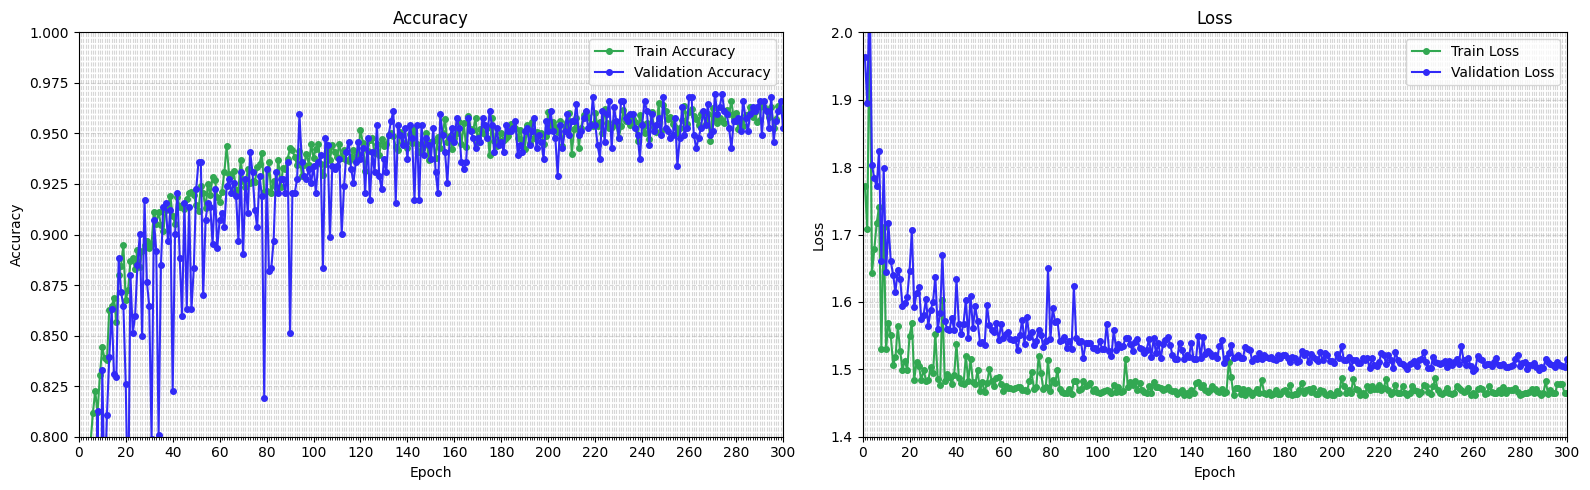

In [16]:
df = pd.read_csv(r'ModelSaves\M2\metrics.csv')

# Find the maximum validation accuracy and the corresponding epoch
max_val_accuracy = df['Validation Accuracy'].max()
max_val_epoch = df[df['Validation Accuracy'] == max_val_accuracy]['Epoch'].values[0]
print(f'Highest validation accuracy: {max_val_accuracy} at epoch: {max_val_epoch}')

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

# Plot the accuracy
axs[0].plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy', marker='o', markersize=4, color='#32a852')
axs[0].plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy', marker='o', markersize=4, color='#312af7')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy')
axs[0].set_ylim(acc_min_y, 1)
axs[0].set_xlim(1, num_epochs)
axs[0].legend()
major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
minor_ticks = np.arange(0, num_epochs + 1, 1)
axs[0].set_xticks(major_ticks)
axs[0].set_xticks(minor_ticks, minor=True)
axs[0].set_xticklabels(major_ticks.astype(int))
axs[0].grid(True, which='both', linestyle='--', alpha=0.5)

# Plot the loss
axs[1].plot(df['Epoch'], df['Train Loss'], label='Train Loss', marker='o', markersize=4, color='#32a852')
axs[1].plot(df['Epoch'], df['Validation Loss'], label='Validation Loss', marker='o', markersize=4, color='#312af7')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Loss')
axs[1].set_ylim(1.4, 2)
axs[1].set_xlim(1, num_epochs)
axs[1].legend()
major_ticks = np.arange(0, num_epochs + 1, major_tick_spacing)
minor_ticks = np.arange(0, num_epochs + 1, 1)
axs[1].set_xticks(major_ticks)
axs[1].set_xticks(minor_ticks, minor=True)
axs[1].set_xticklabels(major_ticks.astype(int))
axs[1].grid(True, which='both', linestyle='--', alpha=0.5)

# Show the plots
plt.tight_layout()
plt.show()


## Test Model

In [ ]:
path = r'ModelSaves\M2\M2_epoch_271_loss_1.4690_vloss1.5069_acc_0.9571_vacc0.9696.pt'

model = torch.load(path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

In [22]:
from sklearn.metrics import classification_report

true_labels = []
pred_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs) 
        _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.numpy().tolist())
        pred_labels.extend(preds.cpu().numpy().tolist())

report = classification_report(true_labels, pred_labels, output_dict=True)

print(f'Precision: {report["macro avg"]["precision"]}')
print(f'Recall: {report["macro avg"]["recall"]}')
print(f'F1 score: {report["macro avg"]["f1-score"]}')


Precision: 0.9691420399131312
Recall: 0.9694164524957861
F1 score: 0.9690412348965143


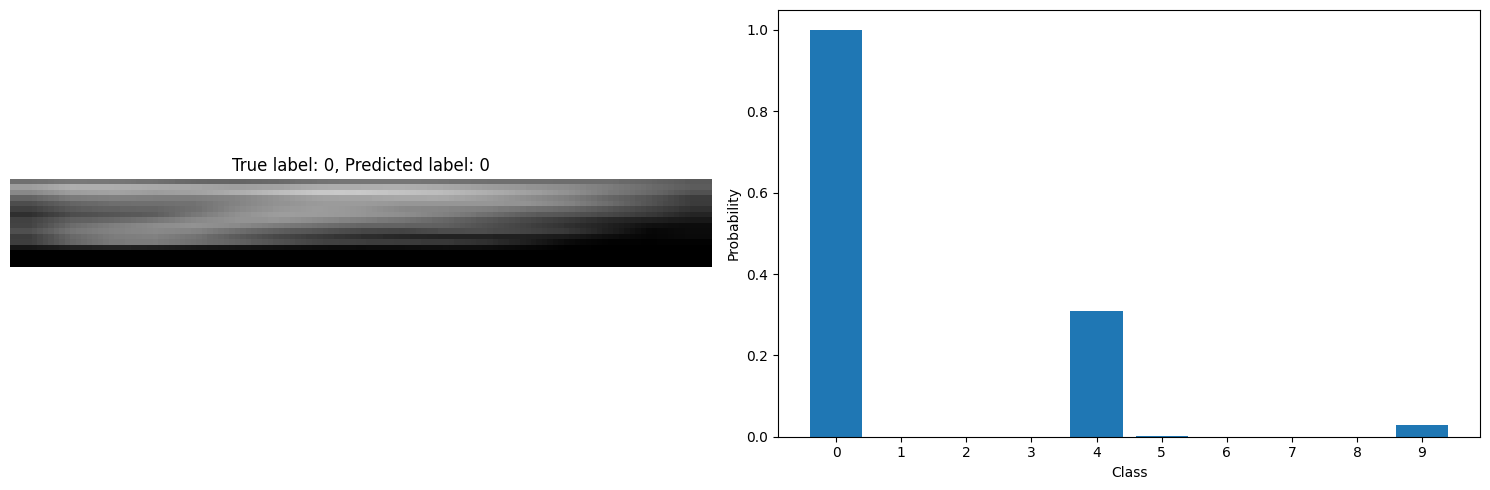

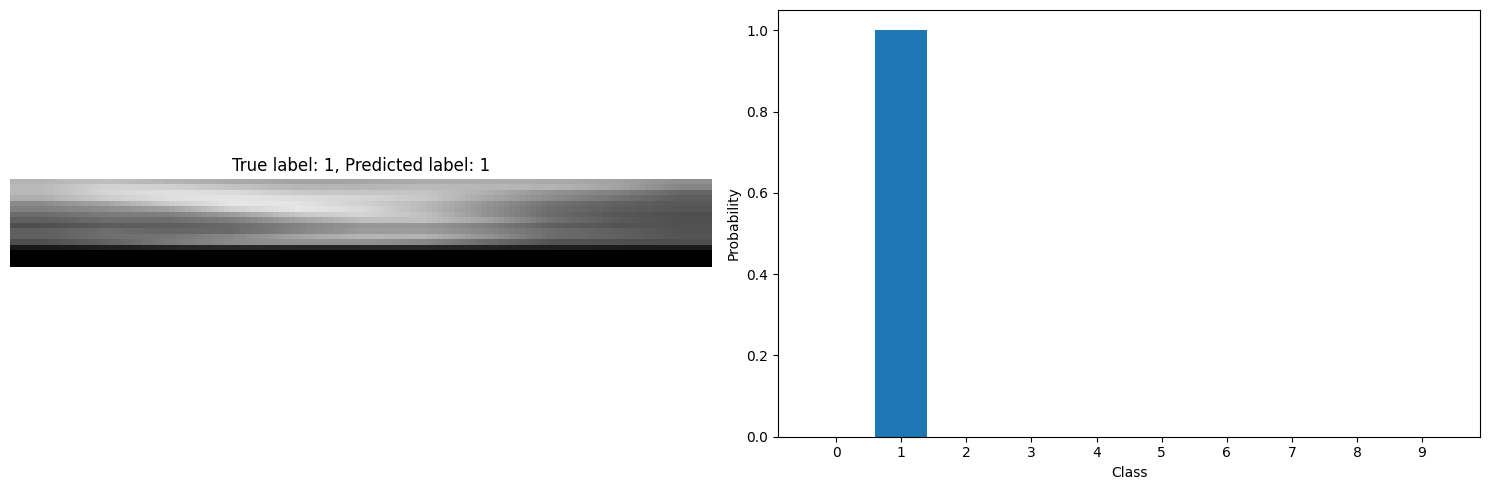

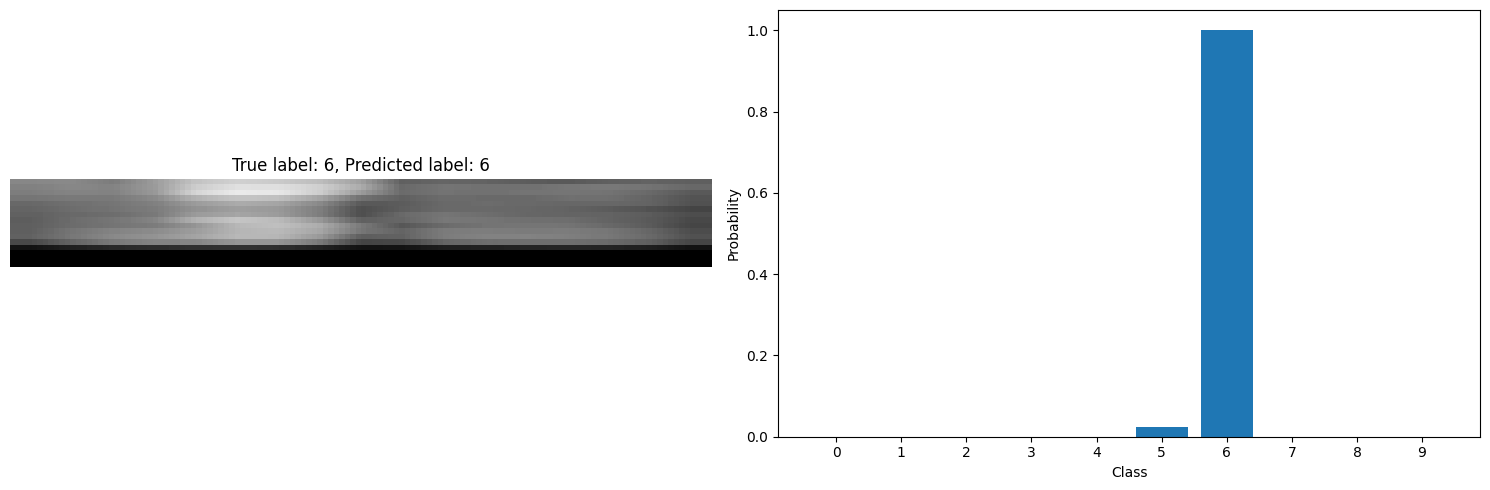

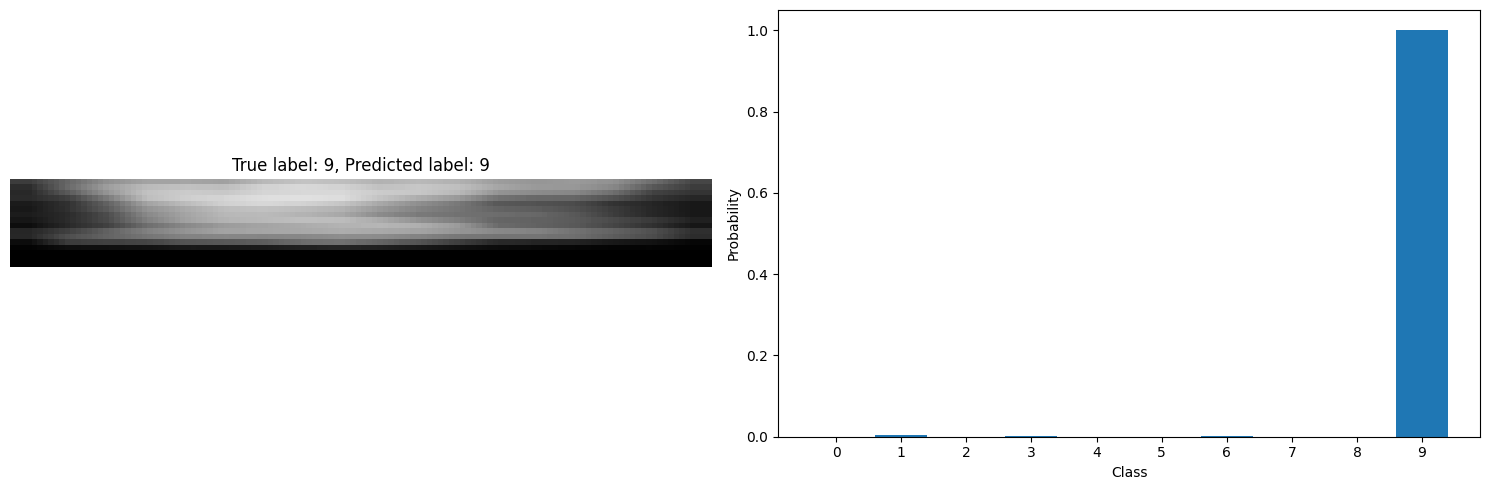

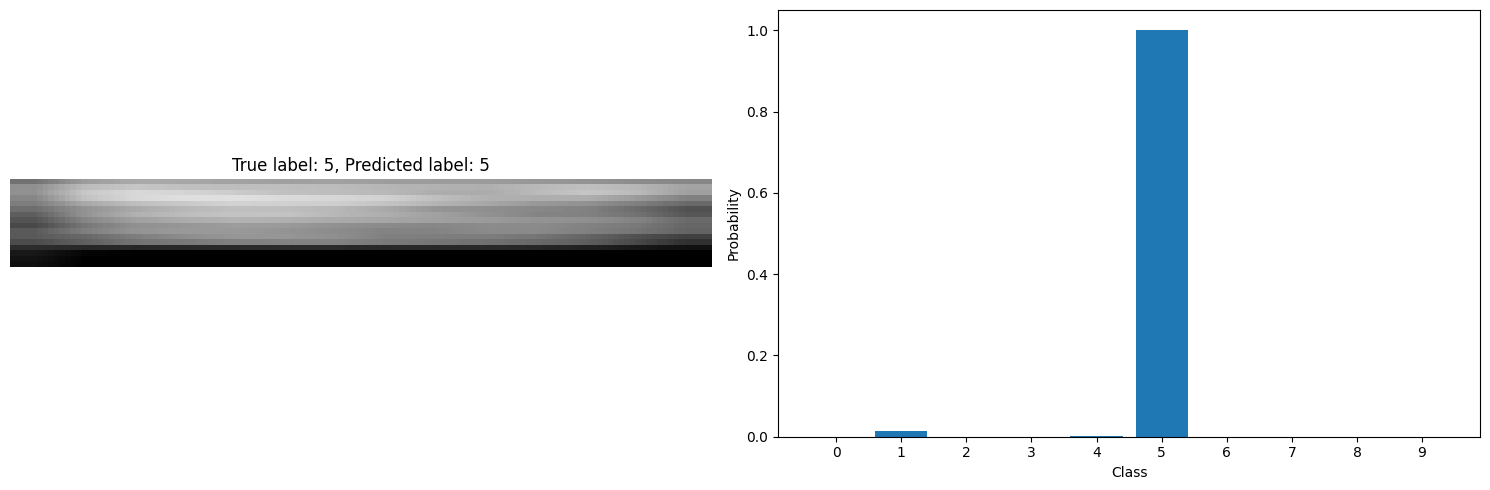

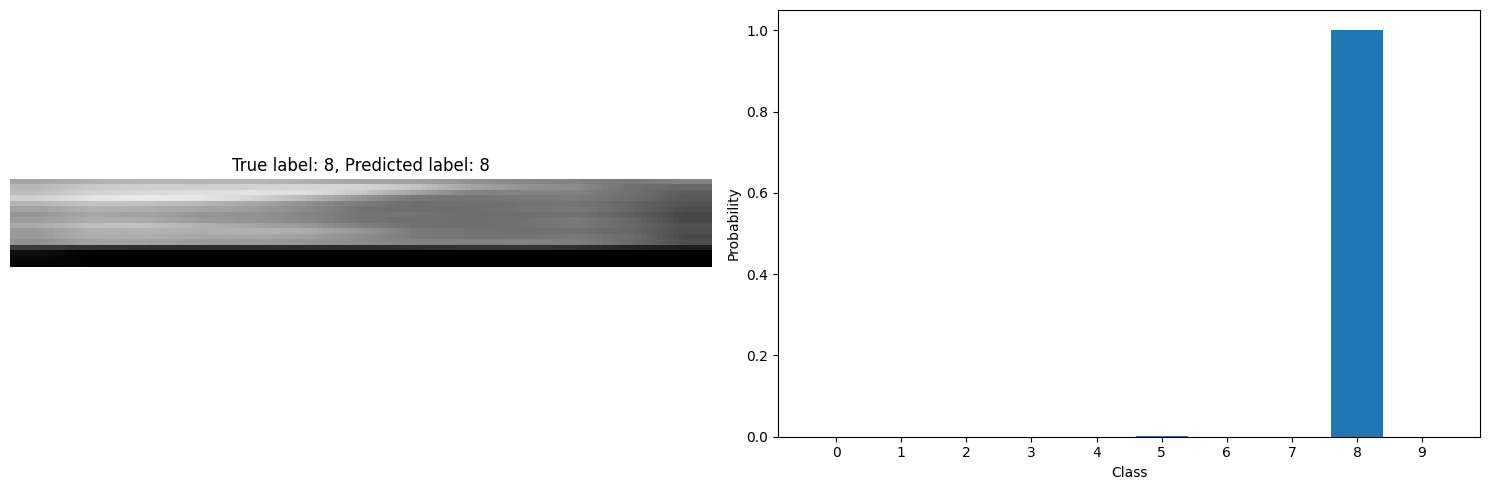

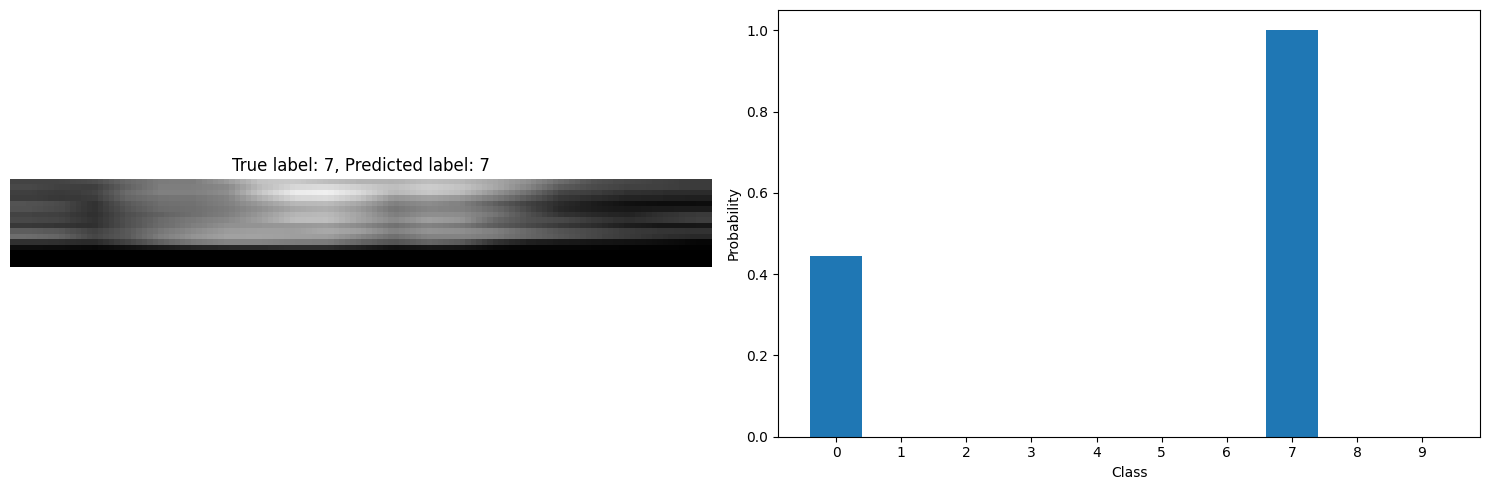

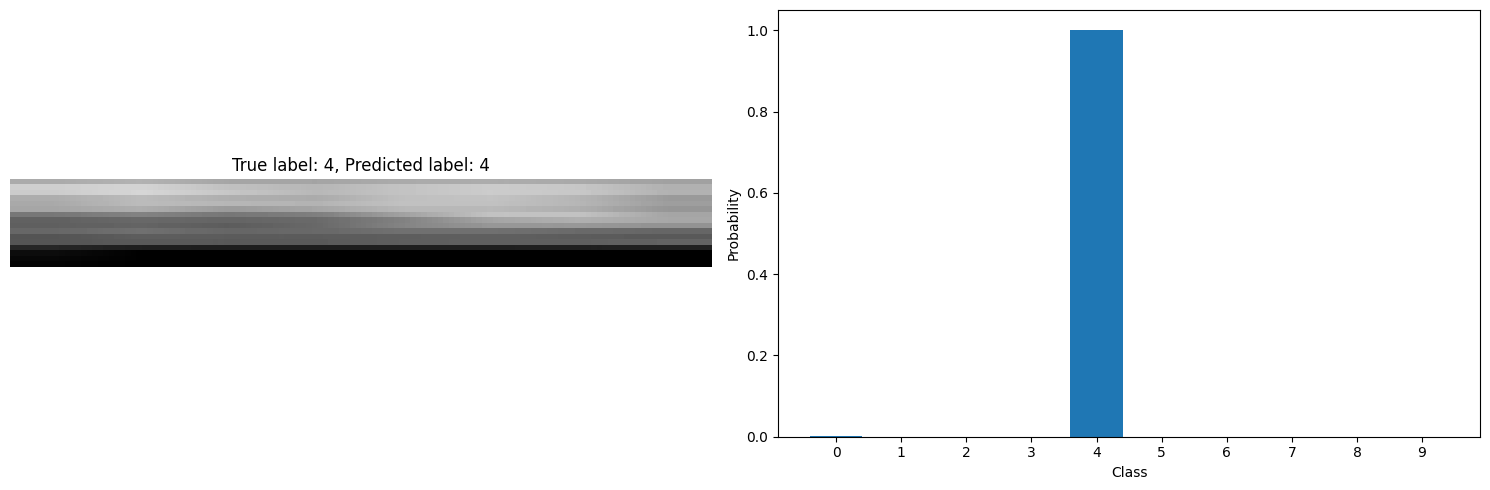

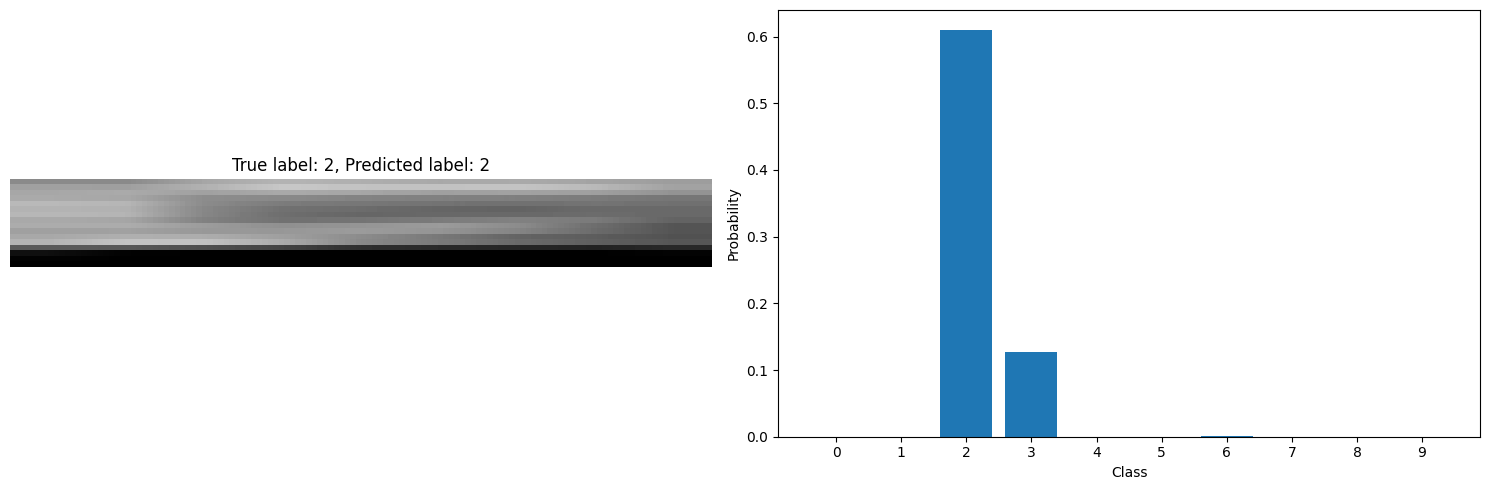

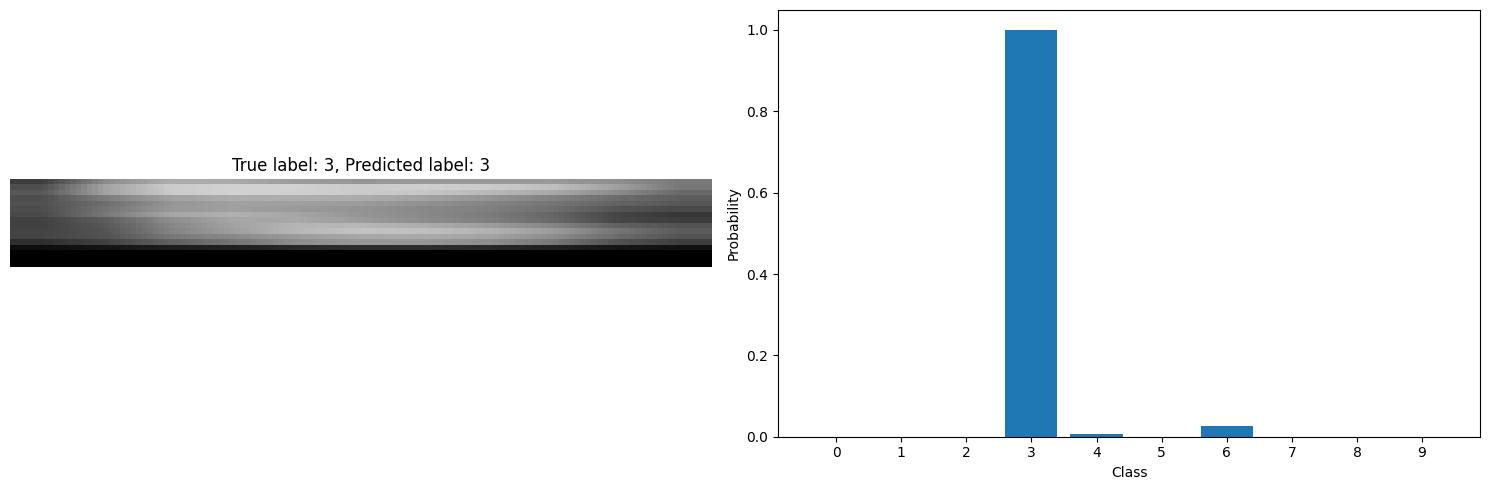

In [23]:
def show_predictions(model, test_dataset, num_images_per_class):
    model.eval()

    # Initialize a dictionary to store the indices of the first occurrence of each class
    class_indices = {}

    # Iterate over the test dataset to find the first occurrence of each class
    for index, (_, label) in enumerate(test_dataset):
        if label not in class_indices:
            class_indices[label] = index

    # Iterate over the class indices and display the specified number of images for each class
    for label, index in class_indices.items():
        for i in range(num_images_per_class):
            if i == 0:
                input_image, _ = test_dataset[index]
            else:
                input_image, _ = test_dataset[index + i]

            with torch.no_grad():
                input_image = input_image.to(device)

                output = model(input_image.unsqueeze(0))
                _, predicted = torch.max(output, 1)
                predicted_label = predicted.item()

            image = input_image.squeeze().cpu().numpy()

            fig, axs = plt.subplots(1, 2, figsize=(15, 5))
            if len(image.shape) == 3:
                sample_image = np.transpose(image, (1, 2, 0))
            elif len(image.shape) == 2:
                sample_image = image

            axs[0].imshow(sample_image,
                          cmap='gray',
                          vmin=0, vmax=1)
            axs[0].set_title("True label: {}, Predicted label: {}".format(label, predicted_label))
            axs[0].axis('off')

            probability = output.cpu()[0].detach().numpy()

            classes = ['0', '1', '2', '3', '4',
                     '5', '6', '7', '8', '9']

            axs[1].bar(classes, probability)
            axs[1].set_xlabel('Class')
            axs[1].set_ylabel('Probability')

            # Rotate the x-axis labels vertically
            #axs[1].tick_params(axis='x', rotation=90)

            plt.tight_layout()
            plt.show()

# Call the function to show predictions
num_images_per_class = 1  # Specify the number of images per class
show_predictions(model, test_dataset, num_images_per_class)